In [51]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/C57-Females-all/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
data_file = "/work/mk423/C57-Females-all/c57_female_epm_data.pkl"
proj_file = PROJECT_PATH + "c57_female_epm_projection_complete.csv"
bxcx_proj_file = PROJECT_PATH + "bxcx_c57_female_epm_projection.csv"

mean_file = PROJECT_PATH + "c57_female_epm_mean_scores_complete.csv"
bxcx_mean_file = PROJECT_PATH + "bxcx_c57_female_epm_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


FEATURE_LIST = ['X_psd','X_coh','X_gc']
FEATURE_WEIGHT = [10,1,1]


def get_3_net_aucs(s,y,y_group=None):
    
    auc_mean_list = []
    auc_stderr_list =[]
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        mean = np.mean([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"])
        stderr = np.std([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"]) / np.sqrt(len(auc_dict.keys()))
        
        auc_mean_list.append(mean)
        auc_stderr_list.append(stderr)
        
    return auc_mean_list, auc_stderr_list

def get_3_net_auc_dict(s,y,y_group=None):
    auc_dict_list = []
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        auc_dict_list.append(auc_dict)
        
    return auc_dict_list

In [30]:
dataDict = pickle.load(open(data_file,"rb"))

X = np.hstack([weight*dataDict[feature] for weight,feature in zip(FEATURE_WEIGHT,FEATURE_LIST)])
y_time = dataDict['y_time']
y_mouse = np.array(dataDict['y_mouse'])
y_task = dataDict['y_task']
y_expDate = dataDict['y_expDate']
s = model.project(X)
coeffs = model.classifier[0].weight[0].detach().cpu().numpy()
s_comp = s[:,:3] @ coeffs

In [8]:
model.score_mw(X,y_task,y_mouse,return_dict=True)

{'Mouse0870': 0.6436194761739933,
 'Mouse0871': 0.8078671328671329,
 'Mouse0872': 0.5283251231527094,
 'Mouse0873': 0.883139962933814,
 'Mouse22273': 0.4871309208765722,
 'Mouse22292': 0.5637645005222937,
 'Mouse22294': 0.8244047619047619,
 'Mouse34491': 0.43410138248847924}

In [11]:
from scipy.stats import ttest_1samp

In [13]:
results_dict = model.score_mw(X,y_task,y_mouse,return_dict=True)
auc_list = [results_dict[key] for key in list(results_dict.keys())]

In [16]:
ttest_1samp(auc_list,0.5,alternative="greater")

Ttest_1sampResult(statistic=2.421955476024284, pvalue=0.02298002046433261)

In [23]:
for i in [0,1]:
    results_dict = model.score_mw(X,y_task,y_mouse,return_dict=True,net=i)
    auc_list = [results_dict[key] for key in list(results_dict.keys())]
    print(i)
    print(auc_list)
    print(ttest_1samp(auc_list,0.5,alternative="greater"))
    print(np.mean(auc_list), np.std(auc_list)/np.sqrt(len(auc_list)))

0
[0.6221443406022845, 0.7195687645687646, 0.4401370743199829, 0.8746096625961562, 0.45186286461895275, 0.5551054208587608, 0.8125, 0.5331797235023041]
Ttest_1sampResult(statistic=2.20133963722782, pvalue=0.031802558296539024)
0.6261384813834008 0.05359997301677218
1
[0.6433166032075689, 0.812995337995338, 0.5437459841507818, 0.8765391352915789, 0.49818322381136454, 0.5621185881576777, 0.8184523809523809, 0.4184331797235023]
Ttest_1sampResult(statistic=2.4435243643117777, pvalue=0.0222640773803058)
0.6467230541612742 0.05616757985214398


In [44]:
mouse_list = []


comp_net_mean_hc_score_list = []
comp_net_mean_task_score_list = []
results_dict = model.score_mw(X,y_task,y_mouse,return_dict=True)
comp_net_hc_v_task_auc_list = [results_dict[key] for key in np.unique(y_mouse)]

net_1_mean_hc_score_list = []
net_1_mean_task_score_list = []

results_dict = model.score_mw(X,y_task,y_mouse,return_dict=True,net=0)
net_1_hc_v_task_auc_list = [results_dict[key] for key in np.unique(y_mouse)]

net_2_mean_hc_score_list = []
net_2_mean_task_score_list = []
results_dict = model.score_mw(X,y_task,y_mouse,return_dict=True,net=1)
net_2_hc_v_task_auc_list = [results_dict[key] for key in np.unique(y_mouse)]

net_3_mean_hc_score_list = []
net_3_mean_task_score_list = []
results_dict = model.score_mw(X,y_task,y_mouse,return_dict=True,net=2)
net_3_hc_v_task_auc_list = [results_dict[key] for key in np.unique(y_mouse)]

for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    hc_mask = y_task==0
    task_mask = y_task
    
    comp_net_mean_hc_score = np.mean(s_comp[np.logical_and(mouse_mask,hc_mask)==1])
    print(comp_net_mean_hc_score)
    comp_net_mean_task_score = np.mean(s_comp[np.logical_and(mouse_mask,task_mask)==1])
    
    net_1_mean_hc_score = np.mean(s[np.logical_and(mouse_mask,hc_mask),0])
    net_1_mean_task_score = np.mean(s[np.logical_and(mouse_mask,task_mask),0])
    
    net_2_mean_hc_score = np.mean(s[np.logical_and(mouse_mask,hc_mask),1])
    net_2_mean_task_score = np.mean(s[np.logical_and(mouse_mask,task_mask),1])

    net_3_mean_hc_score = np.mean(s[np.logical_and(mouse_mask,hc_mask),2])
    net_3_mean_task_score = np.mean(s[np.logical_and(mouse_mask,task_mask),2])
    
    mouse_list.append(mouse)
    comp_net_mean_hc_score_list.append(comp_net_mean_hc_score)
    comp_net_mean_task_score_list.append(comp_net_mean_task_score)
    net_1_mean_hc_score_list.append(net_1_mean_hc_score)
    net_1_mean_task_score_list.append(net_1_mean_task_score)
    net_2_mean_hc_score_list.append(net_2_mean_hc_score)
    net_2_mean_task_score_list.append(net_2_mean_task_score)
    net_3_mean_hc_score_list.append(net_3_mean_hc_score)
    net_3_mean_task_score_list.append(net_3_mean_task_score)

3.755386
2.3545005
3.8428452
1.5544158
3.8993037
2.6058738
2.4416416
3.548189


In [41]:
s_comp.shape

(5625,)

In [52]:
mean_proj_dict = {
    "mouse":mouse_list,
    "comp net mean hc score":comp_net_mean_hc_score_list,
    "comp net mean task score":comp_net_mean_task_score_list,
    "comp net hc v task aucs":comp_net_hc_v_task_auc_list,
    
    "net 1 mean hc score":net_1_mean_hc_score_list,
    "net 1 mean task score":net_1_mean_task_score_list,
    "net 1 hc v task aucs":net_1_hc_v_task_auc_list,
    
    "net 2 mean hc score":net_2_mean_hc_score_list,
    "net 2 mean task score":net_2_mean_task_score_list,
    "net 2 hc v task aucs":net_2_hc_v_task_auc_list,
    
    "net 3 mean hc score":net_3_mean_hc_score_list,
    "net 3 mean task score":net_3_mean_task_score_list,
    "net 3 hc v task aucs":net_3_hc_v_task_auc_list,
}

df = pd.DataFrame.from_dict(mean_proj_dict)
df.to_csv(mean_file)

In [46]:
df

,mouse,comp net mean hc score,comp net mean task score,comp net hc v task aucs,net 1 mean hc score,net 1 mean task score,net 1 hc v task aucs,net 2 mean hc score,net 2 mean task score,net 2 hc v task aucs,net 3 mean hc score,net 3 mean task score,net 3 hc v task aucs
0,Mouse0870,3.755386,4.281919,0.643619,0.094382,0.105413,0.622144,0.166449,0.192051,0.643317,0.076916,0.065308,0.379096
1,Mouse0871,2.354501,3.630858,0.807867,0.064664,0.086545,0.719569,0.100254,0.164035,0.812995,0.068469,0.066508,0.484231
2,Mouse0872,3.842845,3.901765,0.528325,0.083157,0.079115,0.440137,0.179248,0.185084,0.543746,0.054790,0.056442,0.524202
3,Mouse0873,1.554416,3.335455,0.883140,0.048020,0.085507,0.874610,0.062566,0.147669,0.876539,0.056495,0.049434,0.437851
4,Mouse22273,3.899304,3.874225,0.487131,0.089751,0.086714,0.451863,0.180082,0.180594,0.498183,0.024326,0.018980,0.419916
5,Mouse22292,2.605874,2.898746,0.563765,0.042376,0.047458,0.555105,0.130489,0.144671,0.562119,0.020852,0.030018,0.608805
6,Mouse22294,2.441642,3.681080,0.824405,0.047583,0.069621,0.812500,0.117656,0.178502,0.818452,0.019112,0.031624,0.616071
7,Mouse34491,3.548189,3.252272,0.434101,0.062839,0.065703,0.533180,0.174287,0.154366,0.418433,0.036899,0.048238,0.630876


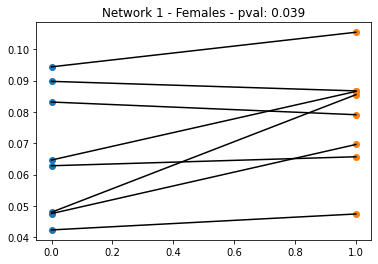

In [47]:
from scipy.stats import wilcoxon as ranksums

x1 = np.zeros(len(net_1_mean_hc_score_list))
y1 = net_1_mean_hc_score_list
x2 = np.ones(len(net_1_mean_hc_score_list))
y2 = net_1_mean_task_score_list

plt.scatter(x1,y1)
plt.scatter(x2,y2)


for mouse in range(len(net_1_mean_hc_score_list)):
    plt.plot([0,1],[y1[mouse],y2[mouse]],color="black")
    
result = ranksums(y2,y1,alternative="greater")
plt.title("Network 1 - Females - pval: {:.3f}".format(result.pvalue))
plt.show()

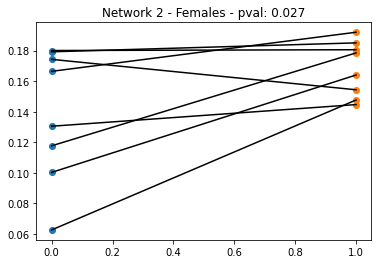

In [48]:
x1 = np.zeros(len(net_2_mean_hc_score_list))
y1 = net_2_mean_hc_score_list
x2 = np.ones(len(net_2_mean_hc_score_list))
y2 = net_2_mean_task_score_list

plt.scatter(x1,y1)
plt.scatter(x2,y2)

for mouse in range(len(net_1_mean_hc_score_list)):
    plt.plot([0,1],[y1[mouse],y2[mouse]],color="black")
result = ranksums(y2,y1,alternative="greater")

plt.title("Network 2 - Females - pval: {:.3f}".format(result.pvalue))
plt.show()